In [22]:
%matplotlib inline
import sys
#sys.path.insert(0, '/home/space/kai/src/Viscid/')
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import viscid
from viscid.plot import vpyplot as vlt
import h5py
import pandas as pd
import os
from mpl_toolkits import mplot3d

viscid.calculator.evaluator.enabled = True

%config InlineBackend.figure_format = 'retina'


from scipy.signal import savgol_filter



#%matplotlib notebook







In [23]:
#Point to directory with the data 
project_dir1="~/UNH/data_m100/"  # 100 mass ratio
project_dir4="~/UNH/data_m400/"  # 400 mass ratio

# Point to single .xdmf file within directory for sim data 
run1 = project_dir1+"/pfd.xdmf"  # mi/me = 100
run4 = project_dir4+"/pfd.xdmf"  # mi/me = 400

vf = viscid.load_file(run4, force_reload=True)



In [121]:
#Functions

#Convenient Plotting
def make_plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(50,3*len(fldnames)))
    if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):
        # Hack around some inconsistencies with the field naming
        if run.endswith(".vpc"):
            map = {
                "bx_fc": "Magnetic Field X",
                "by_fc": "Magnetic Field Y",
                "bz_fc": "Magnetic Field Z",
                "jx": "Free Current Field X",
                "jy": "Free Current Field Y",
                
                "jz": "Free Current Field Z",
                "rho_nc": "Charge Density",
                "qn_nc_e": "Charge Density (ehydro)",
                "qn_nc_i": "Charge Density (Hhydro)",
                "jy_nc_e": "Current Density (ehydro) Y",
            }
        else:
            map = {
                "bx_fc": "hx_fc",
                "by_fc": "hy_fc",
                "bz_fc": "hz_fc",
                "qn_nc_e": "rho_nc_e",
                "qn_nc_i": "rho_nc_i",
            }
        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        _fldname = map[fldname] if fldname in map else fldname
        mid_val = 0
        
        vlt.plot(vf[_fldname], ax=ax[i], **kwargs);
        #plt.scatter(knots[0], knots[2], color = 'k')
        #vlt.plot(vf["psi"],style="contour",levels=50,colors='k', ax=ax[i], **kwargs);




        


        
        
        
        
        
        
# These values change depending on the run used
# specific to 400 mr run for now...
pt = np.array([0, 5, 350])
xl = np.array([0,-10,-200])
xh = xl + np.array([1600,20,400])
gdims = np.array([10240,1,2560])
dx = (xh - xl) / gdims

# Interp function for new Get_fields fuction 
def interp(a, pt):
    n = ((pt - xl)/dx).astype(int)
    return a[n[0],n[1],n[2]]


# New and improved Get_Fields
# Get_Fields is much faster, can do thousands of steps on the order of 1 min
# Does Require interp function above
# (there is probably a ,ore elegant way to do this.  Work for later)
def Get_Fields(r):
    vf.activate_time(t)
    Ex, Ey, Ez = vf['ex_ec'], vf['ey_ec'], vf['ez_ec']
    Bx, By, Bz = vf['hx_fc'], vf['hy_fc'], vf['hz_fc']
    
    
    r = np.array([r[0],0,r[2]]) # This Resets the y position to zero
    Ex = interp(Ex,r)
    Ey = interp(Ey,r)
    Ez = interp(Ez,r)
    Bx = interp(Bx,r)
    By = interp(By,r)
    Bz = interp(Bz,r)
    
    E = np.array([Ex, Ey, Ez])
    B = np.array([Bx, By, Bz])
    
    return E, B

# Boris Push.  Returns particle r, p, kinetic energy (k) at each step
def Push(r0,p0,n):
    #Define position (r) & momentum (p) 
    r = np.zeros((n+1,3))
    p = np.zeros((n+1,3))
    k = np.zeros((n+1,1))

    #Initial r & p
    r[0] = r0
    p[0] = p0
    k[0] = np.linalg.norm(p0)**2 / 2*m

    
    for i in range(n):

            E, B = Get_Fields(r[i])

            # Convenient rotation vector 
            b_rot = q*B*dt/2*m

            # 1st half of electric push
            p_1 = p[i] + q*E*dt/2

            # Rotation by VxB
            #p_2 = p_1 + 2*VxB((p_1 + VxB(p_1,b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)
            p_2 = p_1 + 2*np.cross((p_1 + np.cross(p_1, b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)

            # 2nd half of electric push 
            p[i+1] = p_2 + q*E*dt/2
            r[i+1] = r[i] + p[i+1]*dt/m
            k[i+1] = np.linalg.norm(p[i+1])**2 / 2*m
    
    
    
    
    return r,p,k


# Creates 5 particles in a diamond shape in xz plane with same init momentum
# r0, p0 are central particle coordinates 
# sep is the separation length between central and outer particles
def Bunch(r0, p0, sep):
    r, p = r0, p0             # Center particle
    r1, p1 = np.array([r0[0], r0[1], r0[2] - sep]), p0  # Bottom particle
    r2, p2 = np.array([r0[0], r0[1], r0[2] + sep]), p0  # Top Particle
    r3, p3 = np.array([r0[0] + sep, r0[1], r0[2]]), p0 # Right Particle
    r4, p4 = np.array([r0[0] - sep, r0[1], r0[2]]), p0 # Left Particle
    
    return r, r1, r2, r3, r4

In [4]:
#Particle Stuff to be figured out later

sl = np.array([750,0,-2])
sh = np.array([752,0,-1])
il = ((sl - xl) / dx).astype(int)
ih = ((sh - xl) / dx).astype(int)

t = 17
dirlist = os.listdir(dir)
dirlist = [x for x in dirlist if "prt" in x ]


def read_particles(dir, step=0, proc=0):
    filename = "{}/prt.{:06d}_p{:06d}.h5".format(dir, step, proc)
    file = h5py.File(filename, "r")
    particles = file["particles/p0/1d"]
    idx_begin = file["particles/p0/idx_begin"]
    idx_end = file["particles/p0/idx_end"]

    return particles, idx_begin, idx_end

#This defines the variable ThePrt: a 5 or 6 digit number indicating
#the timestep in the particle output file
if dirlist[t][:5] == 'prt.1':
    ThePrt = int(dirlist[t][4:10]) 
else:
    ThePrt = int(dirlist[t][5:10])

#Read_Particles will force the 2nd argument to be 6 digits anyway, 
# so if ThePrt = 95069 read particles automatically matches the prt format
# with 095069
particles, idx_begin, idx_end = read_particles(dir, ThePrt)
#This defines the variable ThePrt: a 5 or 6 digit number indicating
#the timestep in the particle output file

#particles, idx_begin, idx_end = read_particles(dir, 36568)





def in_cell(kind, iz, iy, ix):
    loc = kind, iz - particle_start[2], iy - particle_start[1], ix - particle_start[0]
    return slice(idx_begin[loc], idx_end[loc])

cnt = 0
slices = []
for iz in range(il[2], ih[2]):
    for ix in range(il[0], ih[0]):
        for kind in range(2):
            r = in_cell(kind, iz, 0, ix)
            cnt += int(r.stop - r.start)
            slices.append(r)
        
s_min = min(s.start for s in slices)
s_max = max(s.stop for s in slices)
    
prt = particles[0]
prts = np.zeros(cnt, dtype=prt.dtype)
cnt = 0
for sl in slices:
    l = int(sl.stop - sl.start)
    prts[cnt:cnt+l] = particles[sl.start:sl.stop]
    cnt += l
    
    
df = pd.DataFrame(prts)




def Particle_Select():
    df['eng_sqrd'] = (df['px']**2 + df['py']**2 + df['pz']**2)
    
    min = df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].min()]
    med = df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].median()]
    max = df.loc[lambda df: df['eng_sqrd'] == df["eng_sqrd"].max()]
    
    minmed = df.loc[lambda df: df['eng_sqrd'] < df["eng_sqrd"].median()]
    minmed = minmed.loc[lambda df: minmed['eng_sqrd'] == minmed["eng_sqrd"].median()]
    
    medmax = df.loc[lambda df: df['eng_sqrd'] > df["eng_sqrd"].median()]
    medmax = medmax.loc[lambda df: medmax['eng_sqrd'] == medmax["eng_sqrd"].median()]
    
    r_min = np.array([min["x"].median(),min["y"].median(),min["z"].median()])
    p_min = np.array([min["px"].median(),min["py"].median(),min["pz"].median()])
    
    r_minmed = np.array([minmed["x"].median(),minmed["y"].median(),minmed["z"].median()])
    p_minmed = np.array([minmed["px"].median(),minmed["py"].median(),minmed["pz"].median()])
    
    r_med = np.array([med["x"].median(),med["y"].median(),med["z"].median()])
    p_med = np.array([med["px"].median(),med["py"].median(),med["pz"].median()])
    
    r_medmax = np.array([medmax["x"].median(),medmax["y"].median(),medmax["z"].median()])
    p_medmax = np.array([medmax["px"].median(),medmax["py"].median(),medmax["pz"].median()])
    
    r_max = np.array([max["x"].median(),max["y"].median(),max["z"].median()])
    p_max = np.array([max["px"].median(),max["py"].median(),max["pz"].median()])

    return r_min, r_minmed, r_med, r_medmax, r_max, p_min, p_minmed, p_med, p_medmax, p_max, 


r0,r1,r2,r3,r4,p0,p1,p2,p3,p4 = Particle_Select()



IndexError: list index out of range

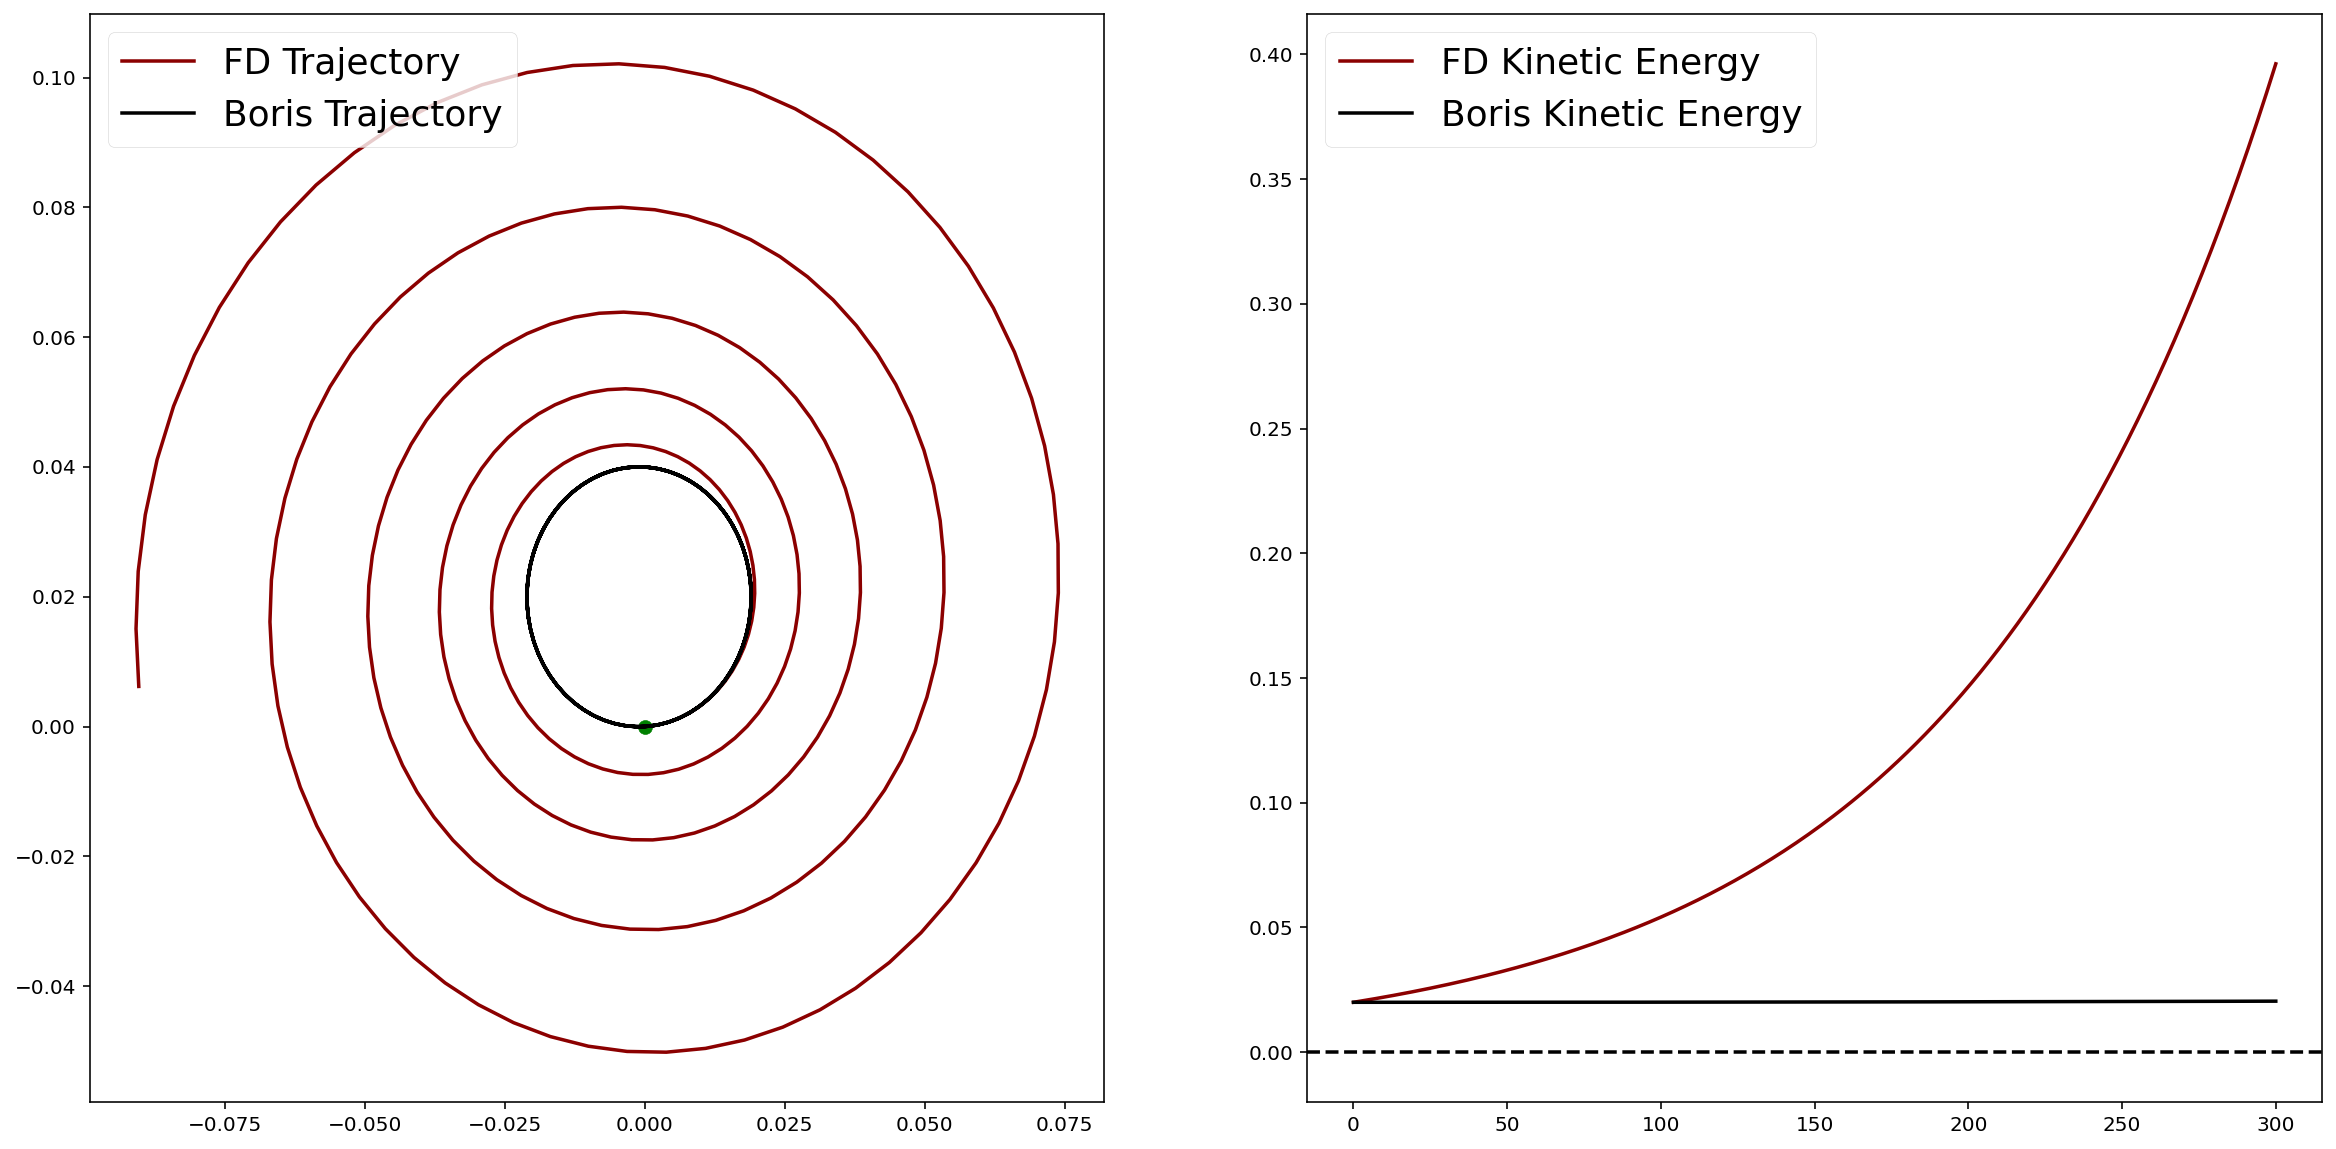

In [66]:
## Use this cell to compare FD vs Boris Push method
m = 1
q = -1
dt = 0.01

r0 = np.array([0,0,0]) 
p0 = np.array([0.2,0,0]) 

#Static Bz & Ez
B = np.array([0, 0, 10])
E = np.array([0, 0, -0.01])


def PushFD(r0,p0,n):
    #Define position (r) & momentum (p) 
    r = np.zeros((n+1,3))
    p = np.zeros((n+1,3))
    k = np.zeros((n+1,1))

    #Initial r & p
    r[0] = r0
    p[0] = p0
    k[0] = np.linalg.norm(p0)**2 / 2*m

    for i in range(n):
        # FD push 
        p[i+1] = p[i] + q*E*dt + q*np.cross(p[i],B)*dt
        r[i+1] = r[i] + p[i+1]*dt
        k[i+1] = np.linalg.norm(p[i+1])**2 / 2*m

    
    return r,p,k

#Demo version of boris push just takes the E and B we define in this cell
def PushB(r0,p0,n):
    #Define position (r) & momentum (p) 
    r = np.zeros((n+1,3))
    p = np.zeros((n+1,3))
    k = np.zeros((n+1,1))

    #Initial r & p
    r[0] = r0
    p[0] = p0
    k[0] = np.linalg.norm(p0)**2 / 2*m

    
    for i in range(n):
            
            #E,B = E,B  # Static fields

            # Convenient rotation vector 
            b_rot = q*B*dt/2*m

            # 1st half of electric push
            p_1 = p[i] + q*E*dt/2

            # Rotation by VxB
            #p_2 = p_1 + 2*VxB((p_1 + VxB(p_1,b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)
            p_2 = p_1 + 2*np.cross((p_1 + np.cross(p_1, b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)

            # 2nd half of electric push 
            p[i+1] = p_2 + q*E*dt/2
            r[i+1] = r[i] + p[i+1]*dt/m
            k[i+1] = np.linalg.norm(p[i+1])**2 / 2*m
    
    
    
    
    return r,p, k

n = 300
r_B,p_B, k_B = PushB(r0, p0, n)
r_FD,p_FD, k_FD = PushFD(r0, p0, n)


fig, ax = plt.subplots(1,2, figsize=(20, 10))

ax[0].plot(r_FD[:,0],r_FD[:,1], 'darkred', label = 'FD Trajectory')
ax[0].plot(r_B[:,0],r_B[:,1], 'k', label = 'Boris Trajectory')
ax[0].scatter(r_FD[0,0], r_FD[0,1], color = 'green')

ax[1].plot(k_FD, color = 'darkred', label = 'FD Kinetic Energy')
ax[1].plot(k_B, color = 'k', label = 'Boris Kinetic Energy')
ax[1].axhline(y = 0, color = 'k', linestyle = '--')



for i in range(0,2):
    ax[i].legend(loc='upper left', prop={'size': 18})




In [70]:
JEe = "ej=(jx_nc_e*ex_ec + jy_nc_e*ey_ec + jz_nc_e*ez_ec)"
JEex = "ejx=(jx_nc_e*ex_ec)"
JEey = "ejy=(jy_nc_e*ey_ec)"
JEez = "ejz=(jz_nc_e*ez_ec)"
JE = "ej=((jx_nc_e + jx_nc_i)*ex_ec + (jy_nc_e + jy_nc_i)*ey_ec + (jz_nc_e + jz_nc_i)*ez_ec)"
JEx = "ejx=((jx_nc_e + jx_nc_i)*ex_ec)"
JEy = "ejy=((jy_nc_e + jy_nc_i)*ey_ec)"
JEz = "ejz=((jz_nc_e + jz_nc_i)*ez_ec)"
# Parallel component of J and E DOES NOT NOT depend on sign of mag field
JPar = "JPar = (jx_nc_e*hx_fc**2 + jy_nc_e*hy_fc**2 + jz_nc_e*hz_fc**2) / ((hx_fc**2 + hy_fc**2 + hz_fc**2)**1)"
EPar = "EPar = (ex_ec*hx_fc**2 + ey_ec*hy_fc**2 + ez_ec*hz_fc**2) / ((hx_fc**2 + hy_fc**2 + hz_fc**2)**1)"
# Parallel contribution to J.E that does NOT depend on sign of mag field
JEPar = "JE Par =  (((jx_nc_e + jx_nc_i)*ex_ec)*(hx_fc**2) + ((jy_nc_e + jy_nc_i)*ey_ec)*(hy_fc**2) + ((jz_nc_e + jz_nc_i)*ez_ec)*(hz_fc**2)) / (hx_fc**2 + hy_fc**2 + hz_fc**2) "
JEPerp = "JE perp =  ((jx_nc_e + jx_nc_i)*ex_ec + (jy_nc_e + jy_nc_i)*jy_nc_e*ey_ec + (jz_nc_e + jz_nc_i)*jz_nc_e*ez_ec) - ((((jx_nc_e + jx_nc_i)*ex_ec)*(hx_fc**2) + ((jy_nc_e + jy_nc_i)*ey_ec)*(hy_fc**2) + ((jz_nc_e + jz_nc_i)*ez_ec)*(hz_fc**2)) / (hx_fc**2 + hy_fc**2 + hz_fc**2)) "
EyPrime = "Ey' = ey_ec + (jz_nc_e * hx_fc)/rho_nc_e - (jx_nc_e * hz_fc)/rho_nc_e "
Te_ParPerp = "Te Par/TPerp - 1 = -1 + ((-1/rho_nc_e)*(hx_fc*txx_nc_e*hx_fc + hy_fc*tyy_nc_e*hy_fc + hz_fc*tzz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))) / ((-1/rho_nc_e)*(txx_nc_e + tyy_nc_e + tzz_nc_e) - (-1/rho_nc_e)*(hx_fc*txx_nc_e*hx_fc + hy_fc*tyy_nc_e*hy_fc + hz_fc*tzz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2)))"
Ti_ParPerp = "Ti Par/TPerp - 1 = -1 + ((1/rho_nc_i)*(hx_fc*txx_nc_i*hx_fc + hy_fc*tyy_nc_i*hy_fc + hz_fc*tzz_nc_i*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))) / ((1/rho_nc_i)*(txx_nc_i + tyy_nc_i + tzz_nc_i) - (1/rho_nc_i)*(hx_fc*txx_nc_i*hx_fc + hy_fc*tyy_nc_i*hy_fc + hz_fc*tzz_nc_i*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2)))"

JEi = "ej=(jx_nc_i*ex_ec + jy_nc_i*ey_ec + jz_nc_i*ez_ec)"
n = "n = rho_nc_e  + rho_nc_i"
Tex = "Te = (txx_nc_e + 0*tyy_nc_e + 0*tzz_nc_e)/3"
Tey = "Te = (0*txx_nc_e + tyy_nc_e + 0*tzz_nc_e)/3"
Tez = "Te = (0*txx_nc_e + 0*tyy_nc_e + tzz_nc_e)/3"
Te_Par = "Te Parallel = (-1/rho_nc_e)*(hx_fc*txx_nc_e*hx_fc + hy_fc*tyy_nc_e*hy_fc + hz_fc*tzz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))"
Te_Perp = "Te Perp = (-1/rho_nc_e)*(txx_nc_e + tyy_nc_e + tzz_nc_e) - (-1/rho_nc_e)*(hx_fc*txx_nc_e*hx_fc + hy_fc*tyy_nc_e*hy_fc + hz_fc*tzz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))"
Ti_Par = "Ti Parallel = (hx_fc*txx_nc_i*hx_fc + hy_fc*tyy_nc_i*hy_fc + hz_fc*tzz_nc_i*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))"
Ti_Perp = "Ti Perp = (txx_nc_i + tyy_nc_i + tzz_nc_i) - (hx_fc*txx_nc_i*hx_fc + hy_fc*tyy_nc_i*hy_fc + hz_fc*tzz_nc_i*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))"


/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

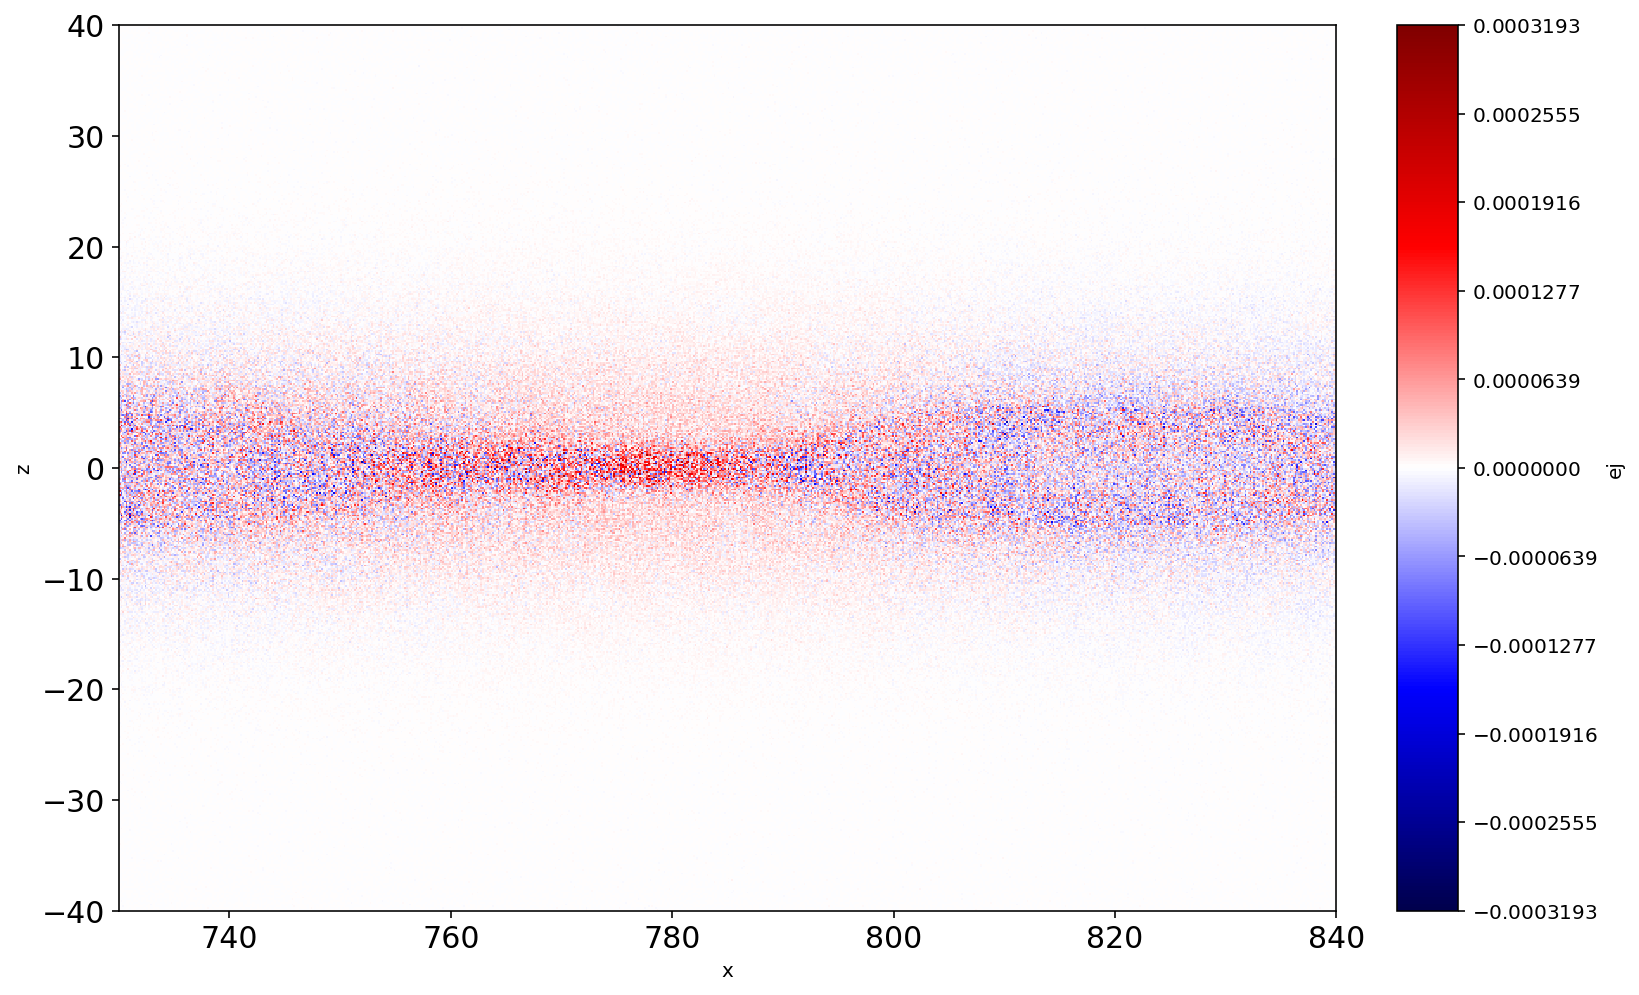

In [122]:
t = 13

vf = viscid.load_file(run4, force_reload=True)
vf.activate_time(t)

plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
fld = JE
vlt.plot(vf[fld], cmap = "seismic", symmetric = "True")
plt.axis("image")
plt.xlim(730,840)
plt.ylim(-40,40)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [135]:
# Particle Diamond - Initializes 5 test particles with a central particle and 4 more surrounding it in a diamond formation for particle tracing
# Useful for looking at the behavior of a small group of particles starting from a similar, but not identical position
# For now, keeping momenta of all 5 identical.  Spacing of surrounding particles from central can be adjusted


# Initial time in simulation
t = 15


# Define init params for the push
# Define central x,y,z coord
x1 = 778
y1 = 0
z1 = 5


# Initialize central particle position & momentum
r0 = np.array([x1,y1,z1]) 
p0 = np.array([0.01,0,0]) 

# Initialize the remaining 4 particles for a diamond formation, define their separation from central coord
r0, r1, r2, r3, r4 = Bunch(r0, p0, 0.1)



In [137]:
# Trying to vary step length while keeping totl time const

m = 1
q = -1
timespan = 2000

dt = 0.5
n = 5000
r,p,k = Push(r0,p0,n)

dt = -0.5
r1,p1,k1 = Push(r[-1],p[-1],n)

#dt = 1.01
#n = round(timespan/dt)
#r1,p1,k1 = Push(r0,p0,n)

#dt = 0.99
#n = round(timespan/dt)
#r2,p2,k2 = Push(r0,p0,n)


#r3,p3,k3 = Push(r0,p0,n)
#r4,p4,k4 = Push(r0,p0,n)

In [83]:
# Define mass, charge (1, -1 for electron) and time interval dt

m = 1
q = -1
dt = 1

# Define number of steps in push (total time = n*dt)
n = 2000

# Push Particles
r,p,k = Push(r0,p0,n)
r1,p1,k1 = Push(r1,p0,n)
r2,p2,k2 = Push(r2,p0,n)
r3,p3,k3 = Push(r3,p0,n)
r4,p4,k4 = Push(r4,p0,n)

In [159]:
p[-2] - p1[2]

array([-0.00100443,  0.01463633, -0.02269984])

/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

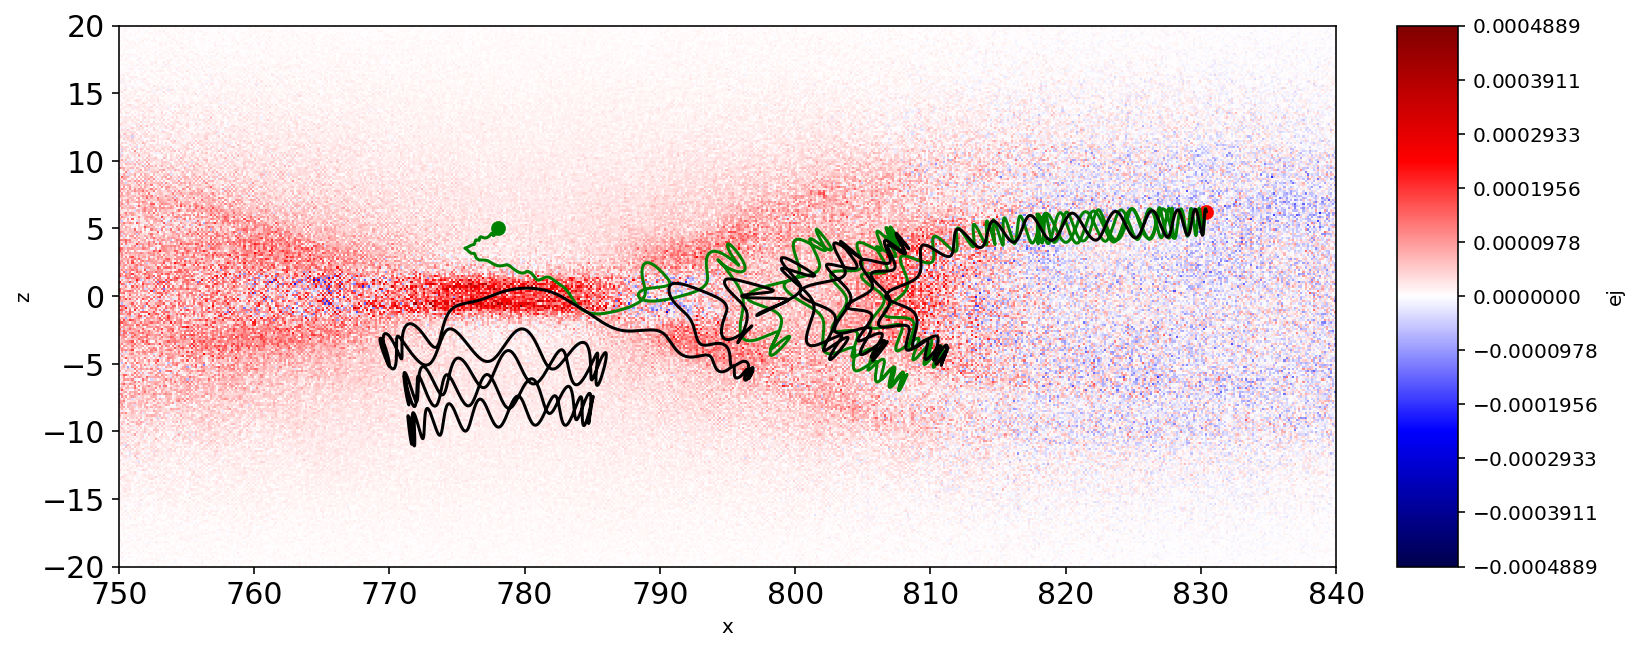

In [148]:
#---------------------------
## Plotting
#---------------------------


plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
fld = JE
vlt.plot(vf[fld], cmap = "seismic", symmetric = "True")
#vlt.plot(fp["psi"],style="contour",levels=50,colors='k', ax=ax[i], **kwargs);
plt.axis("image")
plt.xlim(750,840)
plt.ylim(-20,20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
lw = 1.5


plt.plot(r[:,0],r[:,2],linewidth = lw, color = 'green')
plt.scatter(r[0,0],r[0,2], s = 50, c = 'green')

plt.plot(r1[:,0],r1[:,2], linewidth = lw, color =  'k')
plt.scatter(r1[0,0],r1[0,2], s = 50, c = 'red')

#plt.plot(r2[:,0],r2[:,2],linewidth = lw,color= 'green')
#plt.scatter(r2[0,0],r2[0,2], s = 10, c = 'green')



Text(0.5, 0, 'N')

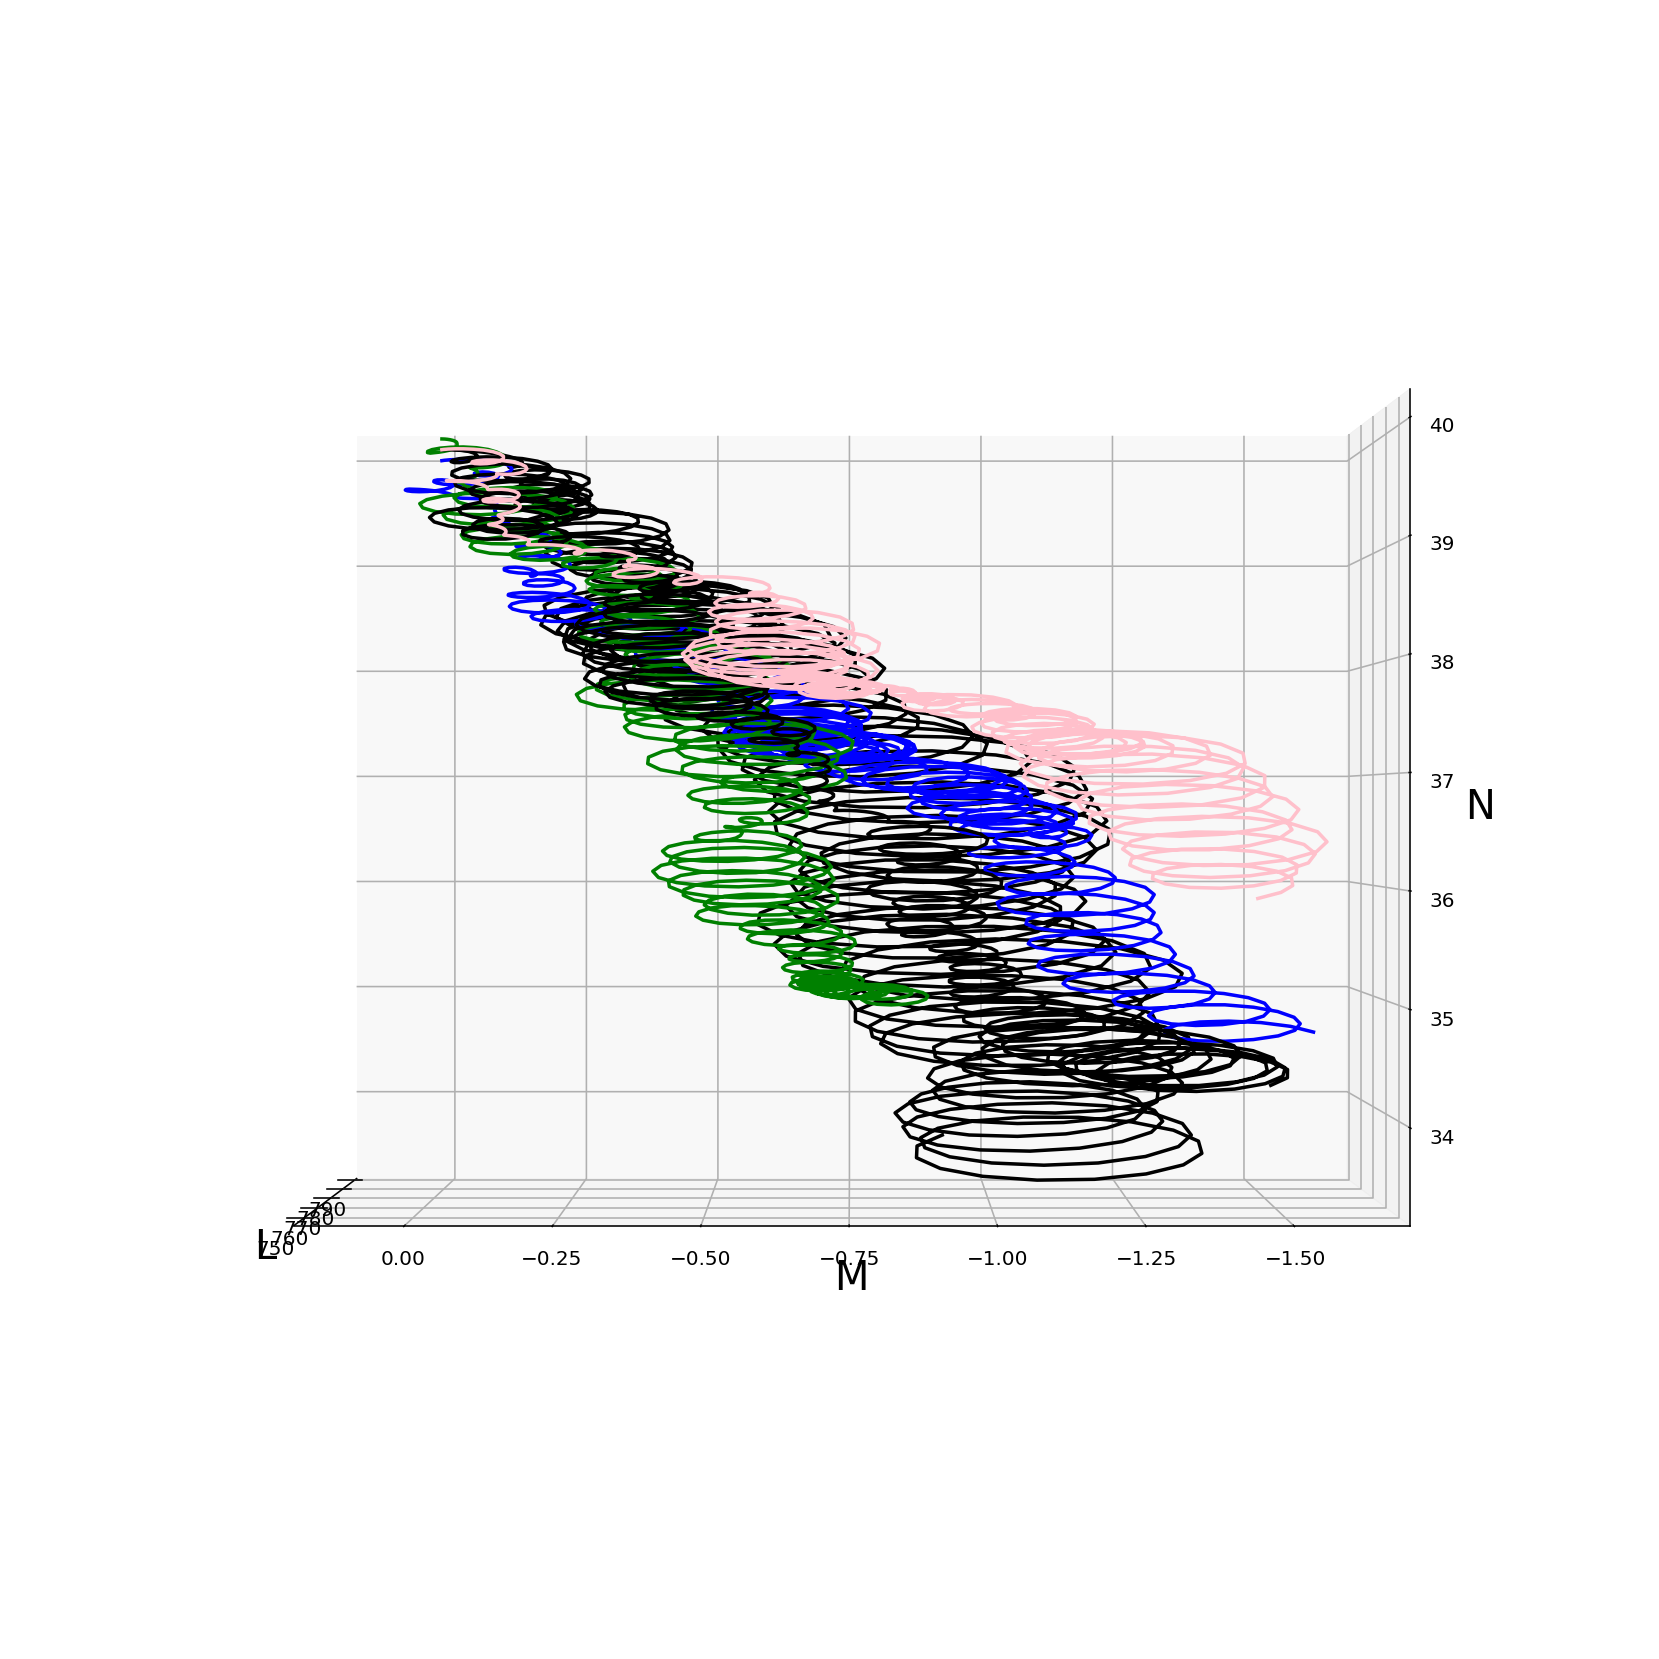

In [85]:


fig = plt.figure(figsize=(15,15))
end = 1000
ax = plt.axes(projection="3d")
ax.plot3D(r[:end,0],r[:end,1],r[:end,2], 'black')
ax.plot3D(r1[:end,0],r1[:end,1],r1[:end,2], 'blue')
ax.plot3D(r2[:end,0],r2[:end,1],r2[:end,2], 'green')
ax.plot3D(r3[:end,0],r3[:end,1],r3[:end,2], 'black')
ax.plot3D(r4[:end,0],r4[:end,1],r4[:end,2], 'pink')

ax.view_init(0, 180) #orientation angles


ax.set_xlabel('L', fontsize = 20)
ax.set_ylabel('M', fontsize = 20)
ax.set_zlabel('N', fontsize = 20)
#ax.set_ylim(-10, 10)
#ax.set_zlim(-30, 30)
#ax.plot3D(r5[:,0],r5[:,1],r5[:,2], 'orange')
#s = 70